In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import keras
import tensorflow as tf
import scipy
import sklearn

In [3]:
from Dataset.HodaDatasetReader import read_hoda_cdb, read_hoda_dataset

In [4]:
hoda = scipy.io.loadmat('Dataset/archive/Data_hoda_full.mat')

In [5]:
print(hoda['Data'].shape)

(60000, 1)


In [6]:
data = hoda['Data'].reshape(-1)
labels = hoda['labels'].reshape(-1)

In [7]:
depth_factor = 1.2
width_factor = 1.1
resolution_factor = 1.1
input_shape = (int(32 * resolution_factor), int(32 * resolution_factor))
n_classes = 10

In [8]:
for i in range(1,6):
    print(data[i].shape)
data_resized = np.array([cv2.resize(img, dsize=input_shape) for img in data])
print("-----------")
for i in range(1,6):
    print(data_resized[i].shape)

(20, 21)
(10, 15)
(36, 17)
(36, 28)
(12, 14)
-----------
(35, 35)
(35, 35)
(35, 35)
(35, 35)
(35, 35)


In [9]:
data_norm = data_resized / 255

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_norm, labels, test_size=0.2, random_state=42)

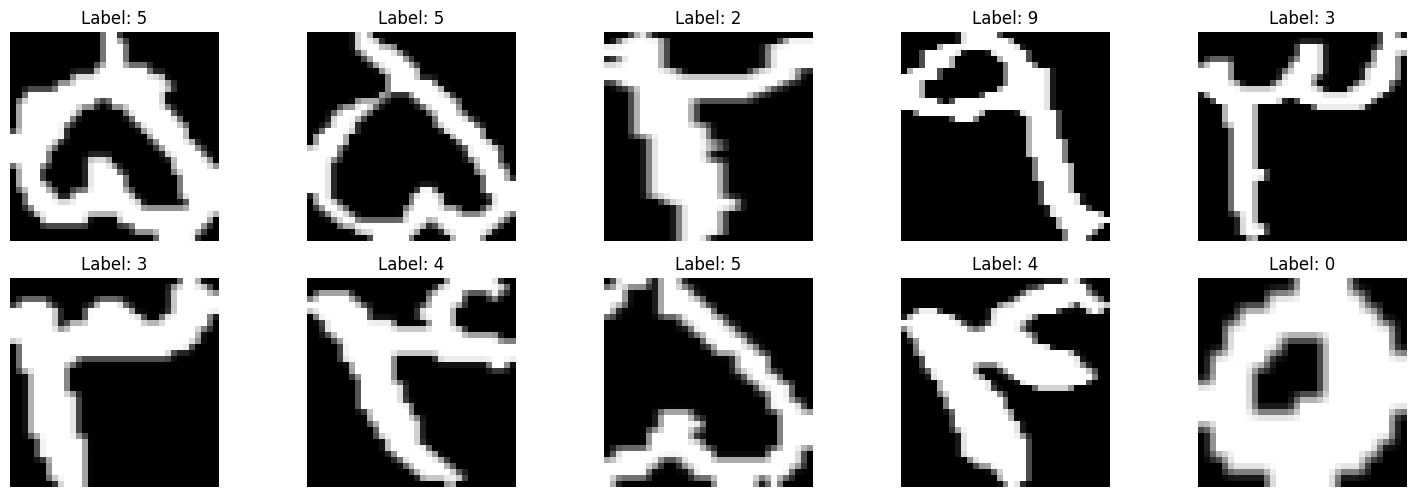

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

random_indices = random.sample(range(X_train.shape[0]), 10)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[idx].reshape(input_shape[0], input_shape[1]), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_test_cat = keras.utils.to_categorical(y_test,n_classes)

In [13]:
import keras
from keras.layers import Dense
from keras.models import Sequential

In [14]:
num_classes = 10

In [15]:
from keras import layers, models

In [16]:
def build_efficientnet(input_shape, num_classes, depth_factor=1.0, width_factor=1.0):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(int(32 * width_factor), (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    for _ in range(int(2 * depth_factor)):
        x = layers.Conv2D(int(64 * width_factor), (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    for _ in range(int(3 * depth_factor)):
        x = layers.Conv2D(int(128 * width_factor), (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(int(128 * width_factor), activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model
input_shape = (int(32 * resolution_factor), int(32 * resolution_factor), 1)
num_classes = 10
model = build_efficientnet(input_shape, num_classes, depth_factor, width_factor)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35, 35, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 35, 35, 35)        350       
                                                                 
 batch_normalization (Batch  (None, 35, 35, 35)        140       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 35, 35, 35)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 70)        22120     
                                                                 
 batch_normalization_1 (Bat  (None, 35, 35, 70)        280       
 chNormalization)                                            

In [18]:
model.compile(loss = 'categorical_crossentropy',optimizer='adam', 
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train_cat, batch_size=32, epochs=10, validation_data=(X_test, y_test_cat))

Epoch 1/10


I0000 00:00:1724496676.409512   41496 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - 86s 54ms/step - loss: 0.1478 - accuracy: 0.9603 - val_loss: 0.0886 - val_accuracy: 0.9736
Epoch 2/10
1500/1500 [==============================] - 81s 54ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0742 - val_accuracy: 0.9739
Epoch 3/10
1500/1500 [==============================] - 82s 54ms/step - loss: 0.0331 - accuracy: 0.9899 - val_loss: 0.0662 - val_accuracy: 0.9782
Epoch 4/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.0467 - val_accuracy: 0.9851
Epoch 5/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.3700 - val_accuracy: 0.8928
Epoch 6/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0650 - val_accuracy: 0.9814
Epoch 7/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.8129 - val_accura

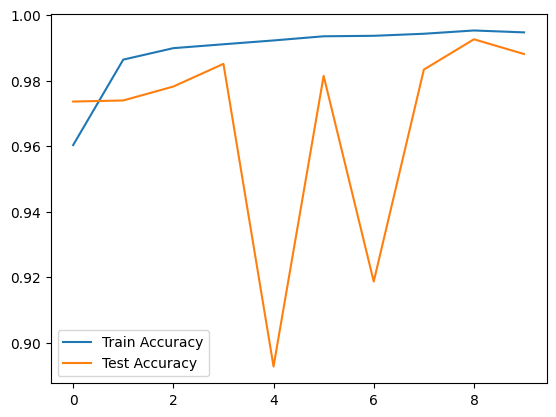

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()